# dask作为算力池

可以理解为dask的数据结构只是计算框架的一个语法糖,它的本质还是任务调度系统,事实上基本所有分布式计算框架的本质都是任务调度系统.因为分布式计算说白了就是把大任务拆分为小任务然后交给很多机器一起执行,然后再回收结果.

那我们就可以利用dask的底层api将其作为算力池来使用.

需要注意的是分布式计算通常都要求函数无[副作用](https://baike.baidu.com/item/%E5%87%BD%E6%95%B0%E5%89%AF%E4%BD%9C%E7%94%A8/22723425?fr=aladdin).也就是说我们定义的函数不应该使用全局变量,不应该改变对象属性.

## 使用delayed接口构造任务链

***注意:delayed接口中不能使用标准dask的数结构***

[delayed]()接口被设计成用于计算标准dask数据结构无法解决的问题.当然通常我们需要使用delayed的场景也都用不到这个接口.这个接口的作用相当于是向集群发布一条由python函数组成的命令,因此使用delayed接口就分解为了两个问题:

+ 怎样构造由python函数组成的命令(计算图)

+ 集群如何执行由python函数组成的命令

In [1]:
from dask.distributed import Client
client = Client('localhost:8786') 

### 构造由python函数组成的命令


dask通过[delayed](https://docs.dask.org/en/latest/delayed-api.html#)接口注册函数构造计算图,使用计算图来控制分发运算.在构造好计算图后,执行`.compute()`接口发布命令计算结果.下面的例子是官方给出的典型计算---每个元素加一加上每个元素加2之后再所有结果合起来相加

In [2]:
import dask
def inc(x):
    return x + 1

def double(x):
    return x + 2

def add(x, y):
    return x + y

data = [1, 2, 3, 4, 5]

output = []
for x in data:
    a = dask.delayed(inc)(x)
    b = dask.delayed(double)(x)
    c = dask.delayed(add)(a, b)
    output.append(c)

total = dask.delayed(sum)(output)

In [3]:
total.compute()

45

#### 使用装饰器`delayed`构造计算图

`delayed`也可以作为装饰器,这样在定义函数时就可以同时构造计算图了.这种方式其实并不推荐,因为这样反而降低了灵活性,不利于扩展

In [4]:
@dask.delayed
def inc1(x):
    return x + 1
@dask.delayed
def double1(x):
    return x + 2
@dask.delayed
def add1(x, y):
    return x + y

data = [1, 2, 3, 4, 5]

output = []
for x in data:
    a = inc1(x)
    b = double1(x)
    c = add1(a, b)
    output.append(c)
total1 = dask.delayed(sum)(output)

In [5]:
total1.compute()

45

#### 自定义计算图

实际上dask可以用户自定义计算图,我们通过将计算过程编码到一个dict对象构造计算图,然后使用`dask.threaded.get`接口将计算图送入集群来计算,`get`的第一个参数是计算图,第二个是计算图中定义的key.注意计算图中的key可以是字符串或者tuple.更多关于自定义计算图的优化方法需要看下[相关文档](https://docs.dask.org/en/latest/optimize.html)

In [6]:
from dask.threaded import get

In [7]:
def inc(i):
    return i + 1

def add(a, b):
    return a + b

In [8]:
d = {'x': 1,
     'y': (inc, 'x'),
     'z': (add, 'y', 10)}

In [9]:
get(d, 'x')

1

In [10]:
get(d, 'z')

12

#### 计算图的高级接口

[计算图的高级接口](https://docs.dask.org/en/latest/high-level-graphs.html)允许我们为计算分层

In [11]:
from dask.highlevelgraph import HighLevelGraph
import pandas as pd
import operator

layers = {
   'read-csv': {('read-csv', 0): (pd.read_csv, 'myfile.0.csv'),
                ('read-csv', 1): (pd.read_csv, 'myfile.1.csv'),
                ('read-csv', 2): (pd.read_csv, 'myfile.2.csv'),
                ('read-csv', 3): (pd.read_csv, 'myfile.3.csv')},

   'add': {('add', 0): (operator.add, ('read-csv', 0), 100),
           ('add', 1): (operator.add, ('read-csv', 1), 100),
           ('add', 2): (operator.add, ('read-csv', 2), 100),
           ('add', 3): (operator.add, ('read-csv', 3), 100)},

   'filter':{('filter', 0): (lambda part: part[part.name == 'Alice'], ('add', 0)),
              ('filter', 1): (lambda part: part[part.name == 'Alice'], ('add', 1)),
              ('filter', 2): (lambda part: part[part.name == 'Alice'], ('add', 2)),
              ('filter', 3): (lambda part: part[part.name == 'Alice'], ('add', 3))}
}

dependencies = {'read-csv': set(),
                'add': {'read-csv'},
                'filter': {'add'}}

graph = HighLevelGraph(layers, dependencies)

#### 计算图可视化

`visualize()`接口可以将计算图可视化,这需要安装可选依赖[python-graphviz](https://www.graphviz.org/)

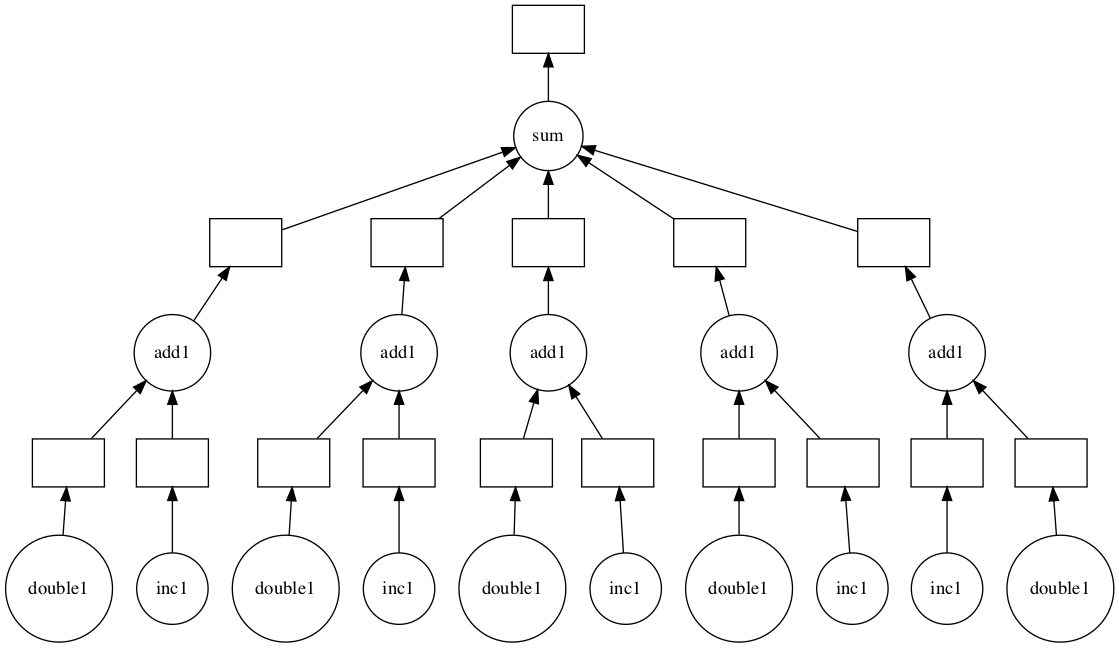

In [12]:
total1.visualize()

### 集群执行由python函数组成的命令

要让集群可以执行命令,需要整个集群的python环境有对应需要的全部依赖,如果我们使用的swarm模式或者k8s模式部署的集群,那我们就需要为镜像单独安装依赖.一个比较好的方式是继承镜像重新打包:

```dockerfile
FROM daskdev/dask:latest
RUN conda install pytorch

ENTRYPOINT ["tini", "-g", "--", "/usr/bin/prepare.sh"]
```